<a href="https://colab.research.google.com/github/saspav/python_for_pro/blob/main/HW_ML_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='green' size='7'>**Домашняя работа**</font>  
<font color='#11a642' size='6'>**Тема: Машинное обучение. Ансамбли моделей**</font>  
<font size='5'>**Задание:**</font>  

Домашняя работа основана на данных конкурса https://www.kaggle.com/competitions/playground-series-s5e5  

**Что нужно сделать:**

1. Загрузить данные c конкурса  https://www.kaggle.com/competitions/playground-series-s5e5
2. Построить ансамбли моделей


**Форма загрузки на платформу:** строго файл ipynb. Перед загрузкой еще раз запустите ноутбук, убедившись, что все работает корректно без ошибок






# <font color='#11a642' size='6'> **Импорт и установка библиотек**

In [1]:
!pip install catboost -q

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
import random


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (  # Метрики оценки качества модели
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    make_scorer,
)
from collections import Counter

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

# Настройки отображения данных в Pandas
pd.set_option('display.max_columns', 50)  # Отображать до 50 столбцов
pd.set_option('display.precision', 5)  # Отображение ДФ с 5-ю знаками после запятой

In [3]:
# Зафиксируем сиды

SEED = 127
np.random.seed(SEED)
random.seed(SEED)

In [4]:
# Переиспользуем все функции с прошлого ноутбука

def memory_compression(df, use_category=True, use_float=True, exclude_columns=None):
    """
    Изменение типов данных для экономии памяти
    :param df: исходный ДФ
    :param use_category: преобразовывать строки в категорию
    :param use_float: преобразовывать float в пониженную размерность
    :param exclude_columns: список колонок, которые нужно исключить из обработки
    :return: сжатый ДФ
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    for col in df.columns:

        if exclude_columns and col in exclude_columns:
            continue

        if str(df[col].dtype)[:4] in 'datetime':
            continue

        elif str(df[col].dtype) not in ('object', 'category'):
            col_min = df[col].min()
            col_max = df[col].max()
            if str(df[col].dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif use_float and str(df[col].dtype)[:5] == 'float':
                if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif (col_min > np.finfo(np.float32).min
                      and col_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

        elif use_category and str(df[col].dtype) == 'object':
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    print(f'Исходный размер датасета в памяти '
          f'равен {round(start_mem, 2)} мб.')
    print(f'Конечный размер датасета в памяти '
          f'равен {round(end_mem, 2)} мб.')
    print(f'Экономия памяти = {(1 - end_mem / start_mem):.1%}')
    return df


def rmsle(y_true, y_pred):
    """
    Расчет метрики Root Mean Squared Logarithmic Error
    :param y_true: y_true
    :param y_pred: y_pred
    :return: RMSLE
    """
    y_true = np.array(y_true)
    y_pred = np.maximum(0, np.array(y_pred))
    return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2))


def get_metrics(y_true, y_pred):
    """
    Расчет метрики Root Mean Squared Logarithmic Error
    :param y_true: y_true
    :param y_pred: y_pred
    :return: метрики
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmsle_ = rmsle(y_true, y_pred)
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2, 'rmsle': rmsle_}


def calculate_outliers(dfs, q_range=1.5):
    """
    Функция для расчета выбросов через IQR
    :param dfs: датафрейм
    :param q_range: диапазон IQR
    :return: маска с выбросами
    """
    Q1 = dfs.quantile(0.25)
    Q3 = dfs.quantile(0.75)
    IQR = (Q3 - Q1) * q_range
    return (dfs < (Q1 - IQR)) | (dfs > (Q3 + IQR))


def train_valid_model(model_class, model_num, model_params, df_train, df_valid,
                      model_cols, target_col, target_log=False):
    """
    Процедура обучения и валидации модели
    :param model_class: Модель, которую используем для обучения
    :param model_num: Порядковый номер модели
    :param model_params: Параметры модели
    :param df_train: обучающий ДФ
    :param df_valid: валидационный ДФ
    :param model_cols: список признаков
    :param target_col: целевая переменная
    :param target_log: логарифмировать целевой признак
    :return: обученная модель, ДФ с метриками, Серия с важностью признаков
    """
    X_train, y_train = df_train[model_cols], df_train[target_col]
    X_valid, y_valid = df_valid[model_cols], df_valid[target_col]

    model = model_class(**model_params, random_state=SEED)

    if target_log:
        # Логарифмируем целевой признак
        model.fit(X_train, np.log1p(y_train))
        # Преобразуем в нормальный масштаб предсказания
        y_pred_train = np.expm1(model.predict(X_train))
        y_pred_valid = np.expm1(model.predict(X_valid))
    else:
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_valid = model.predict(X_valid)

    metrics_train = get_metrics(y_train, y_pred_train)
    metrics_valid = get_metrics(y_valid, y_pred_valid)

    metric_t = f'Train{model_num}'
    metric_v = f'Valid{model_num}'

    # Создаем DataFrame
    metrics = pd.DataFrame({'Metric': list(metrics_train.keys()),
                            metric_t: list(metrics_train.values()),
                            metric_v: list(metrics_valid.values())})

    # Добавляем разницу между train и valid (в %)
    metrics[f'Diff{model_num},%'] = ((metrics[metric_v] - metrics[metric_t])
                                     / metrics[metric_t] * 100).round(2)
    return model, metrics, model.feature_importances_


def find_best_model(metrics_df):
    """
    Процедура поиска лучшей модели по метрикам
    :param metrics_df: ДФ с метриками
    :return: None
    """
    models = []
    for idx, row in metrics_df.iterrows():
        metric_name = row['Metric']

        # Отбираем только численные значения из колонок Valid*
        valid_cols = [col for col in metrics_df.columns if col.startswith('Valid')]
        valid_values = row[valid_cols]

        if metric_name.strip().lower() == 'r2':
            best_col = valid_values.idxmax()
            best_val = valid_values.max()
        else:
            best_col = valid_values.idxmin()
            best_val = valid_values.min()

        models.append(best_col)

        print(f"Метрика: {metric_name:<5} --> лучшая модель: {best_col} ({best_val:.4f})")

    result = Counter(models).most_common()[0]
    print('\nЛучшая модель: {} на {} метриках из {}'.format(*result, len(models)))


def find_depth(model_class, model_params, depths=range(4, 21, 2)):
    """
    Функция поиска оптимальноё глубины деревьев
    :param model_class: Модель, которую используем для обучения
    :param depths: диапазон поиска глубины дерева
    :return: Оптимальная глубина дерева
    """
    train_rmse, valid_rmse = [], []
    for depth in depths:

        model_params['max_depth'] = depth

        _, metrics, _ = train_valid_model(model_class, 0, model_params,
                                          train, valid, model_columns, target)

        # Получаем значения метрик
        t_rmse, v_rmse = metrics[metrics['Metric'] == 'rmse'][['Train0', 'Valid0']].values[0]
        train_rmse.append(t_rmse)
        valid_rmse.append(v_rmse)

        print(f"Depth: {depth:2} | Train RMSE: {t_rmse:6.2f} | Valid RMSE: {v_rmse:6.2f}")

        # Ранняя остановка, если текущий RMSE > минимального найденного,
        # и минимум был хотя бы 2 шага назад
        min_valid_rmse = min(valid_rmse)
        min_index = valid_rmse.index(min_valid_rmse)
        if len(valid_rmse) > min_index + 2 and valid_rmse[-1] > min_valid_rmse:
            print(f"\nРанняя остановка: лучший Valid RMSE ({min_valid_rmse:.2f}) "
                  f"был на глубине {depths[min_index]}")
            break

    plt.figure(figsize=(8, 5))
    plt.plot(depths[:len(train_rmse)], train_rmse, label='Train RMSE', marker='o')
    plt.plot(depths[:len(valid_rmse)], valid_rmse, label='Validation RMSE', marker='o')
    plt.xlabel('Max Depth')
    plt.ylabel('RMSE')
    plt.title('Зависимость RMSE от глубины дерева')
    plt.legend()
    plt.grid(True)
    plt.show()

    return depths[min_index]


def cv_params(model, param_grid, df_train, df_valid,
              model_cols, target_col, target_log=False, cv_folds=3):
    X_train, y_train = df_train[model_cols], df_train[target_col]
    X_valid, y_valid = df_valid[model_cols], df_valid[target_col]

    scoring = 'neg_root_mean_squared_error'

    opt_params = GridSearchCV(
        estimator=model,  # Модель
        param_grid=param_grid,  # Параметры
        scoring=scoring,  # Стратегия валидации
        cv=cv_folds,  # Количество фолдов кросс валидации
        n_jobs=-1,  # Количество потоков для обучения, -1 = все
        verbose=2,
    )

    if target_log:
        # Логарифмируем целевой признак
        opt_params.fit(X_train, np.log1p(y_train))
    else:
        opt_params.fit(X_train, y_train)

    params = opt_params.best_params_

    print(f'Best score: {round(-opt_params.best_score_, 3)}\n')
    print(f'Best parameters: {params}')
    return params

### Выбор метрики для кроссвалидации:
- `neg_mean_absolute_error` (MAE) - **Интерпретируемость**: MAE измеряется в тех же единицах, что и целевая переменная (калории), что удобно для понимания ошибки "на глаз". **Устойчивость к выбросам**: В отличие от MSE (квадрата ошибки), MAE менее чувствителен к экстремальным значениям. **Отрицательное значение**: В `GridSearchCV` используется `neg_MAE`, так как sklearn максимизирует метрику (чем ближе к 0, тем лучше).
- `neg_mean_squared_error` (MSE) – если большие ошибки должны наказываться сильнее.
- `neg_root_mean_squared_error` (RMSE) – как компромисс между MSE и MAE.

Выберем последний вариант `neg_root_mean_squared_error`.

# <font color='#11a642' size='6'> **Загрузка данных**

In [5]:
try:
    df = pd.read_csv('https://drive.google.com/uc?id=1_GGhdAONTOpW3HQcM665rk3CEl7A6r4C')
except:
    df = pd.read_csv('train_сalories.csv')

In [6]:
# на этих данных дальше необходимо разработать модель
df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


На проверке прошлой работы был такой вопрос: А можно ли с уверенностью сказать, что все дубликаты - это дубликаты? вы ведь не оставили поле с индексом, которое, по идее, должно быть PK с точки зрения бизнес смысла.

#### Дополнительное исследование по дубликатам:

In [7]:
# Проверим на уникальность ИД: совпадает ли с количеством строк в ДФ?

len(df) == df.id.nunique()

True

In [8]:
df.id.max()

749999

Если посмотреть данные тестовой выборки с каггла test.csv, с соревнования, откуда был взят файл train_сalories.csv - то там ИД начинается с 750000 до 999999, т.е. это просто индекс и дубли в данных не принесут пользы, т.к. одинаковые данные в тренировки и вализации будут искажать метрики. И для избежания переобучения на одинаковых примерах в разных выборках их следует удалить.

In [9]:
# Колонка "id" не несет смысла - это индекс
df.set_index("id", inplace=True)

## <font color='#11a642' size='5'> Роли для переменных

In [10]:
target = 'Calories'
# Выбираем категориальные колонки (включая строки и категории)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
# Выбираем числовые колонки
num_cols = df.select_dtypes(include=['number']).columns.tolist()

# <font color='#11a642' size='6'> **Разведочный анализ данных**

<font color='#11a642' size='5'>
Оцените размер вашего датасета  

1.   Сколько ГБ ваш датасет
2.   Сколько строк и столбцов



In [11]:
# Сколько ГБ ваш датасет
df.memory_usage(deep=True).sum() / 1024 ** 3

np.float64(0.08801132626831532)

<font color='#11a642' size='5'>
Рекомендуется:

- посмотреть на `df.info()`, `df.describe()`
- визуализировать распределения целевой переменной и признаков (гистограммы, boxplot)
- посмотреть на корреляции (`df.corr()`)
- проверить пропуски

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         750000 non-null  object 
 1   Age         750000 non-null  int64  
 2   Height      750000 non-null  float64
 3   Weight      750000 non-null  float64
 4   Duration    750000 non-null  float64
 5   Heart_Rate  750000 non-null  float64
 6   Body_Temp   750000 non-null  float64
 7   Calories    750000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 51.5+ MB


In [13]:
# Считаем требуемые статистики
df[num_cols].agg(['min', 'max', 'mean', 'median']).T

,min,max,mean,median
Age,20.0,79.0,41.42040,40.0
Height,126.0,222.0,174.69769,174.0
Weight,36.0,132.0,75.14567,74.0
Duration,1.0,30.0,15.42101,15.0
Heart_Rate,67.0,128.0,95.48399,95.0
Body_Temp,37.1,41.5,40.03625,40.3
Calories,1.0,314.0,88.28278,77.0


In [14]:
# Кол-во пропущенных значений по каждому признаку
print("Пропущенные значения по столбцам:")
print(df.isnull().sum())

# Кол-во дубликатов
print("\nКоличество дубликатов в датафрейме:")
print(df.duplicated().sum())

Пропущенные значения по столбцам:
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

Количество дубликатов в датафрейме:
2841


In [15]:
# Удаляем дубликаты
df.drop_duplicates(inplace=True)
print("Количество дубликатов:", df.duplicated().sum())

Количество дубликатов: 0


In [16]:
# Распределение по полу почти поровну.

df[cat_cols].value_counts(normalize=True)

,proportion
Sex,
female,0.50095
male,0.49905


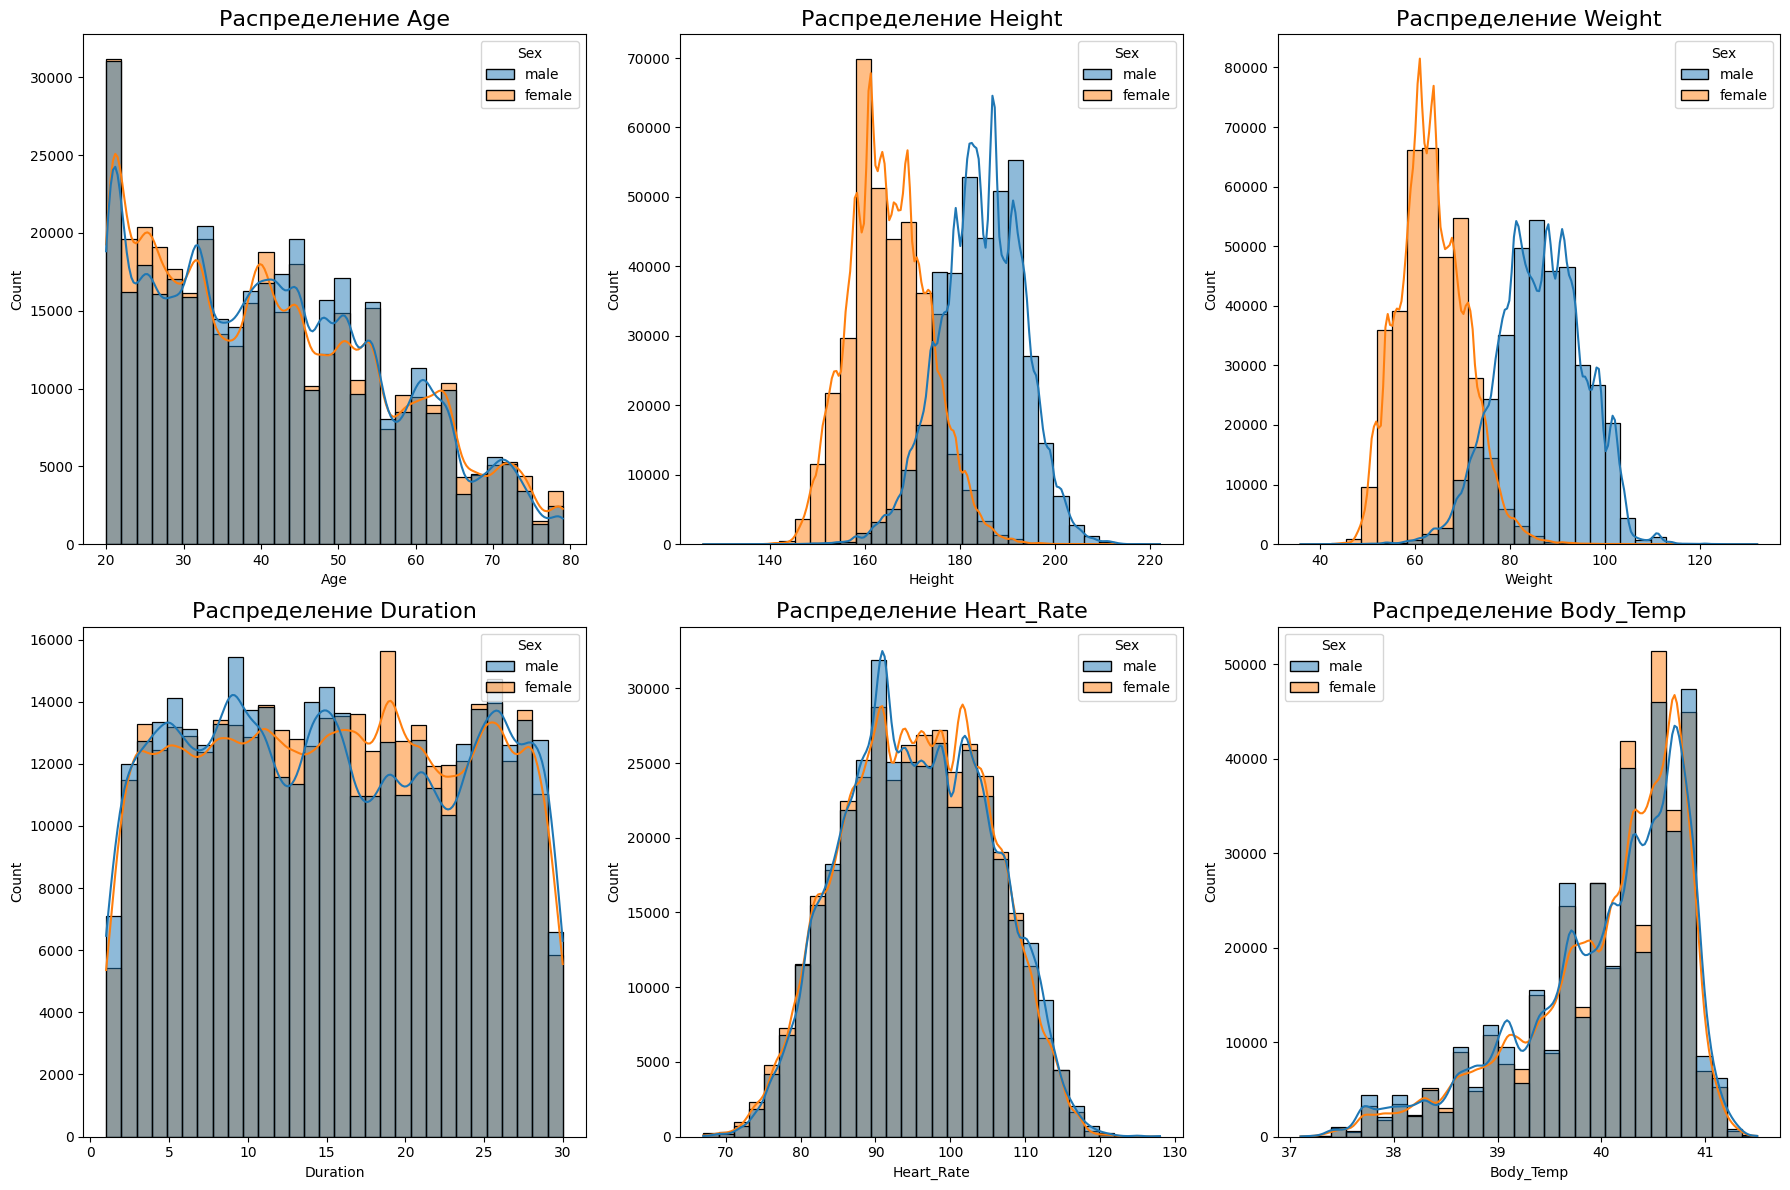

In [17]:
# строим распределение каждого из признаков
numeric_cols = num_cols.copy()
numeric_cols.remove(target)

# Создаем grid графиков
n_cols = 3  # Количество столбцов в grid
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=df, x=col, hue='Sex', bins=30, kde=True, alpha=0.5)
    plt.title(f'Распределение {col}', fontsize=16)
    plt.grid(False)

plt.tight_layout()
plt.show()

Выводы по признакам с учётом **разделения по полу**:

---

### 🔹 **Age (Возраст)**

* **Явно скошенное распределение в сторону молодого возраста**.
* Всплеск на 20 лет — возможно, большое число молодых пользователей, или это нижняя граница по возрасту.
* Постепенное убывание с пиками на круглых датах (30, 40, 50…) — **возможны округления или предпочтения при вводе**.
* Мужчины и женщины распределены схоже.

📌 *Комментарий*: можно рассматривать категориализацию по возрастным группам. Проверить, нет ли "артефактов" (например, 20 лет — подозрительно много).

---

### 🔹 **Height (Рост)**

* Мужчины (синие): максимум около 178–180 см. Широкое распределение, от 160 до 200+.
* Женщины (оранжевые): максимум около 160–165 см, левее и компактнее.

📌 *Комментарий*: чёткое разделение по полу, как ожидается. Распределения адекватны, но **значения ниже 140 см и выше 210 см** — стоит проверить как возможные выбросы.

---

### 🔹 **Weight (Вес)**

* Аналогичная картина: мужчины тяжелее, женщины легче.
* Центры распределений: мужчины — около 80 кг, женщины — 60 кг.
* Некоторая асимметрия: скошенность вправо (особенно у мужчин).

📌 *Комментарий*: значения ниже 45 кг и выше 120 кг — стоит рассматривать как потенциальные выбросы или крайние значения. Распределение выглядит реалистично.

---

### 🔹 **Duration (Длительность)**

* Почти **равномерное распределение** от 1 до 30.
* Пол не влияет — мужские и женские графики совпадают.

📌 *Комментарий*: скорее всего, это **искусственно ограниченный интервал** (возможно, длительность тренировок или сеансов). Можно оставить как есть, или бининговатить.

---

### 🔹 **Heart\_Rate (Пульс)**

* Пульс распределён **нормально**, с пиком около 90–100 уд/мин.
* Мужчины и женщины снова похожи.
* Верхняя граница в 120–130 уд/мин — **в пределах нормы при нагрузке**.

📌 *Комментарий*: Можно создать бинарный признак «пульс выше 100» или «в пределах нормы» для медицины/фитнеса.

---

### 🔹 **Body\_Temp (Температура тела)**

* Распределение **от 37 до 41.5°C** — нехарактерно для нормальной температуры.
* Пик у 40–40.5°C — крайне высокая температура, **что-то не так**:

  * либо это **температура после физической активности** (если измерение по коже или под нагрузкой),
  * либо **единицы не Цельсий**, либо **ошибка сбора**.

📌 *Комментарий*: требует проверки. Средняя температура тела человека — **36.6–37.5°C**, и 40°C — это уже клиническое состояние.

---

### 🟩 Общие выводы:

✅ **Хорошо распределены**: `Age`, `Height`, `Weight`, `Heart_Rate`.

⚠️ **Проверить:**

* `Body_Temp` — вероятная ошибка шкалы или контекста измерения.

* Сделать **бокс-плоты** для `Weight`, `Height`, `Body_Temp`, `Calories` — выявить выбросы.

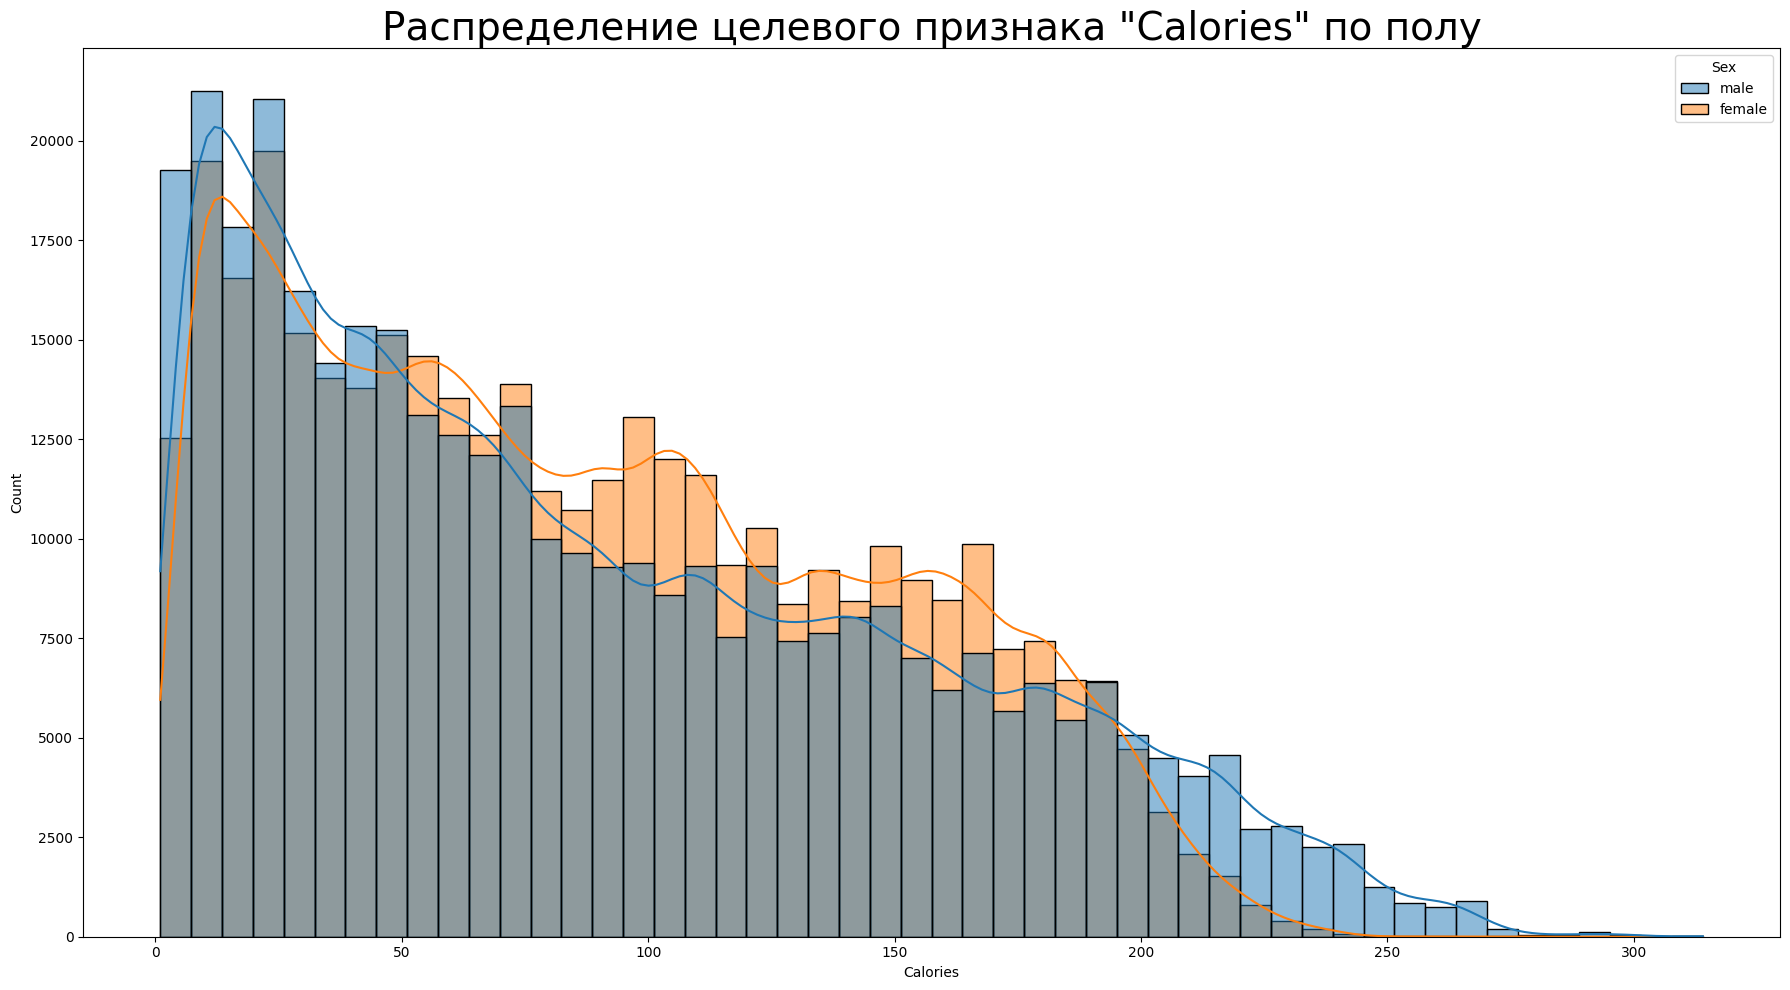

In [18]:
plt.figure(figsize=(18, 10))

sns.histplot(data=df, x=target, hue='Sex', bins=50, kde=True, alpha=0.5)
plt.title(f'Распределение целевого признака "{target}" по полу', fontsize=28)
plt.grid(False)

plt.tight_layout()
plt.show()

---

## 🔍 Распределение **Calories** (целевая переменная):

* **Распределение явно скошено влево** (асимметричное, с длинным "хвостом" вправо).
* Большинство значений лежит в пределах **0–150**, пик около **20–40 ккал**.
* Есть значения вплоть до **300+ ккал**, но они **редкие** — это **длинный хвост**, возможно, выбросы.
* Мужчины в среднем сжигают **больше калорий**, чем женщины:

  * У мужчин хвост правее, больше наблюдений с калориями >200.
  * У женщин максимум ближе к 80–120.

---

## 📌 Выводы:

1. **Распределение ненормальное**, высокая скошенность:

   * Это может затруднить регрессию если в качестве метрики взять MSE).
   * Рекомендуется **логарифмическое преобразование**: `log1p(Calories)` — устранит перекос.

2. **Выбросы**:

   * Значения выше **250–300 ккал** — **крайние и редкие**, стоит проверить:

     * корректны ли они?
     * не стоит ли обрезать/нормализовать?

3. **Различие по полу**:

   * Пол влияет на распределение — можно:

     * обучать отдельные модели на мужчин и женщин.

---

## ✅ Рекомендации:

* Добавить лог-преобразованную целевую переменную: `Calories_log = np.log1p(Calories)`.
* Визуализировать распределение `Calories_log`, чтобы проверить, стало ли оно ближе к нормальному.
* Проверить выбросы: можно построить boxplot или обрезать `Calories > 300`.

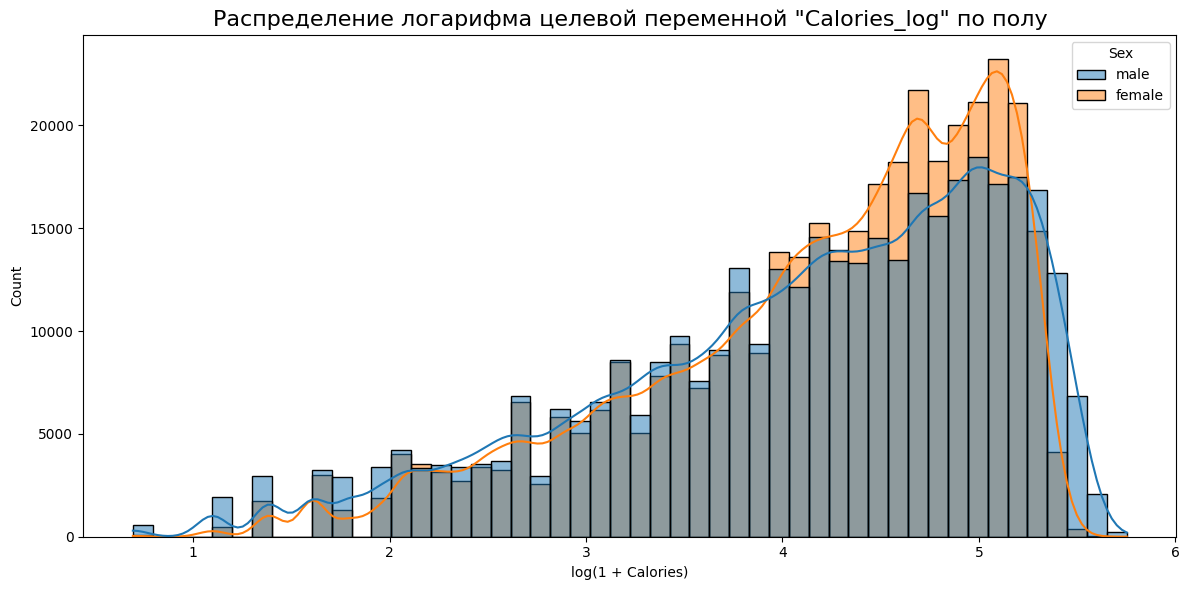

In [19]:
df['Calories_log'] = np.log1p(df['Calories'])

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Calories_log', hue='Sex', bins=50, kde=True, alpha=0.5)
plt.title('Распределение логарифма целевой переменной "Calories_log" по полу', fontsize=16)
plt.xlabel('log(1 + Calories)')
plt.grid(False)
plt.tight_layout()
plt.show()

Преобразование log1p(Calories) было успешным: распределение стало более нормальным, различия по полу сохранились, и данные стали лучше подходить для регрессии. Нужно попробовать в качестве целевой переменной использовать `Calories_log = np.log1p(Calories)`



## Поиск и анализ выбросов

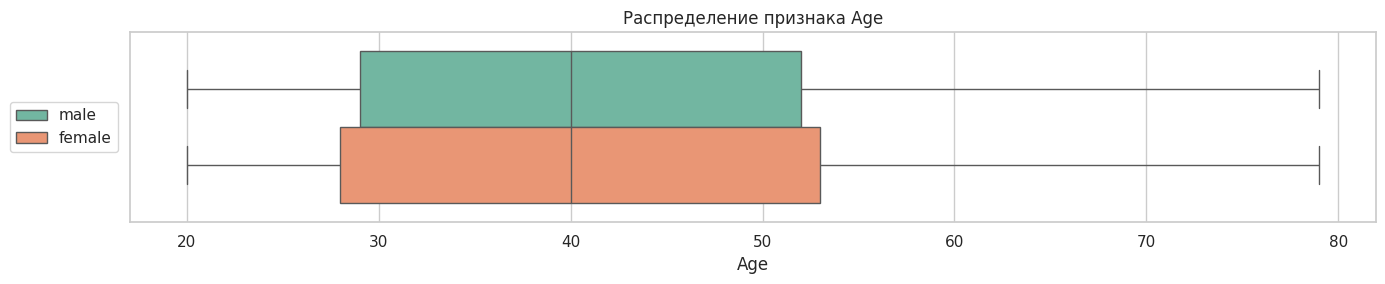

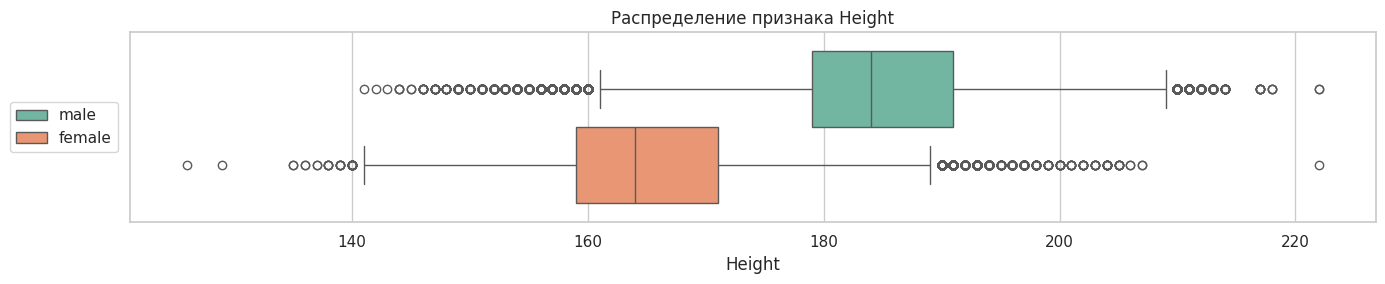

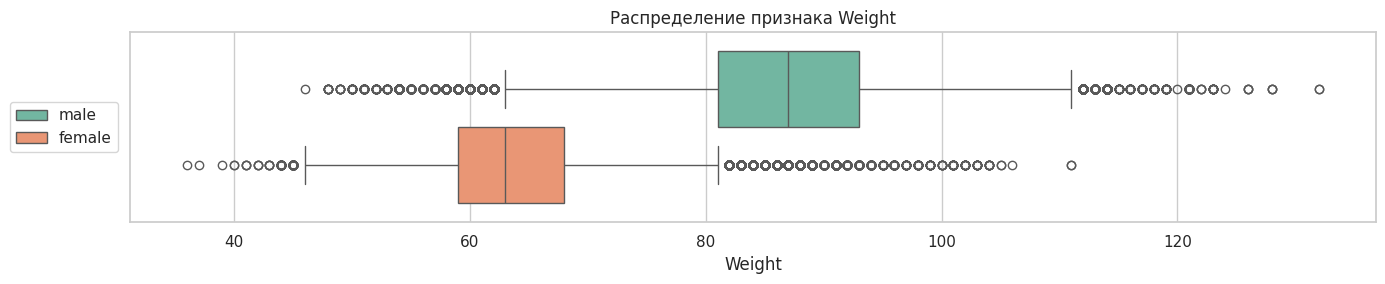

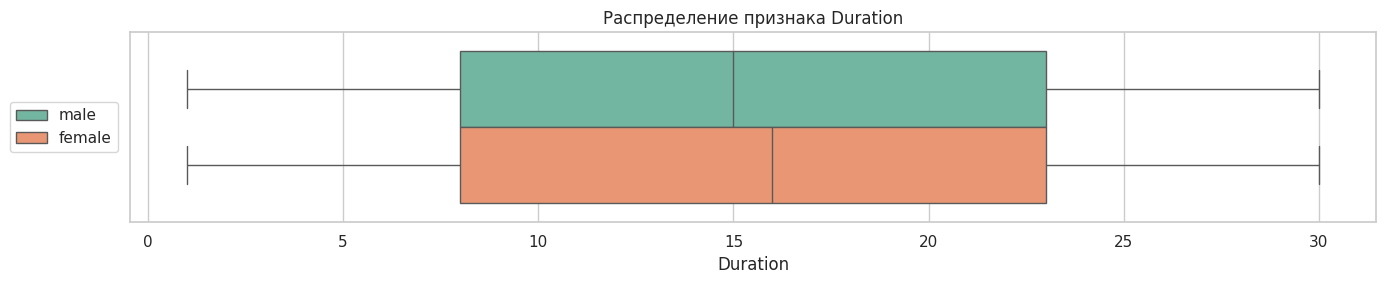

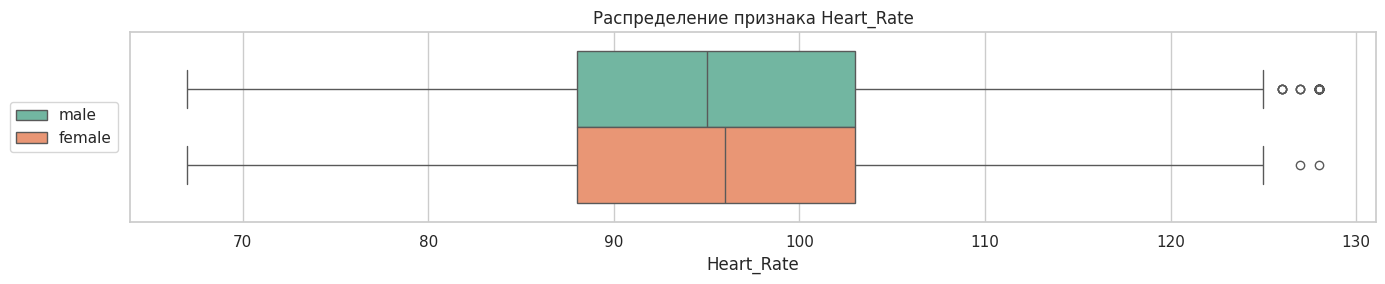

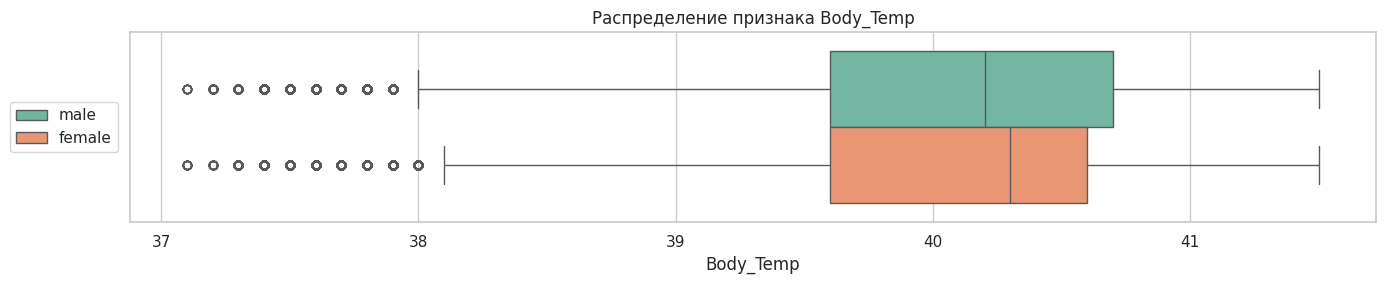

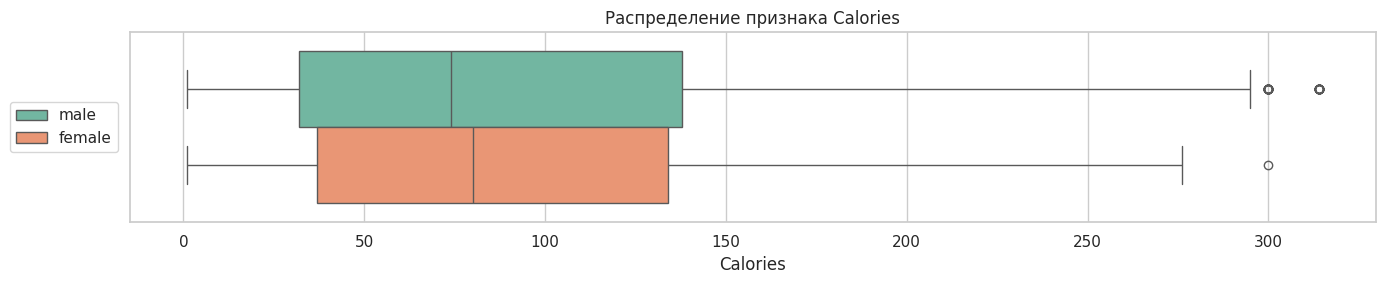

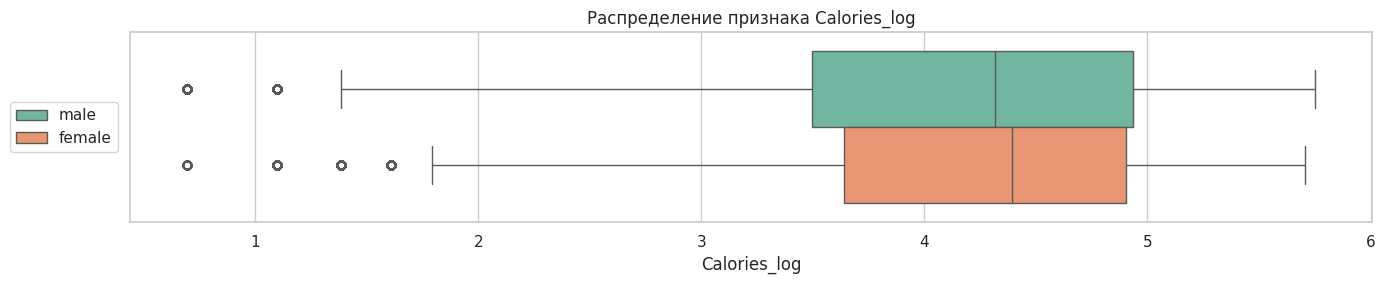

In [20]:
sns.set(style='whitegrid')

for col in num_cols + ['Calories_log']:
    plt.figure(figsize=(14, 3))
    sns.boxplot(data=df, x=col, hue='Sex', palette='Set2', legend=True)
    plt.title(f'Распределение признака {col}')
    # Перемещаем легенду в левую часть и центрируем по высоте
    plt.legend(bbox_to_anchor=(-0.01, 0.5), loc='center right', borderaxespad=0)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

Визуально определяются выбросы в признаках Height и Weight. Можно попробовать избавиться от них на тренировочных данных.

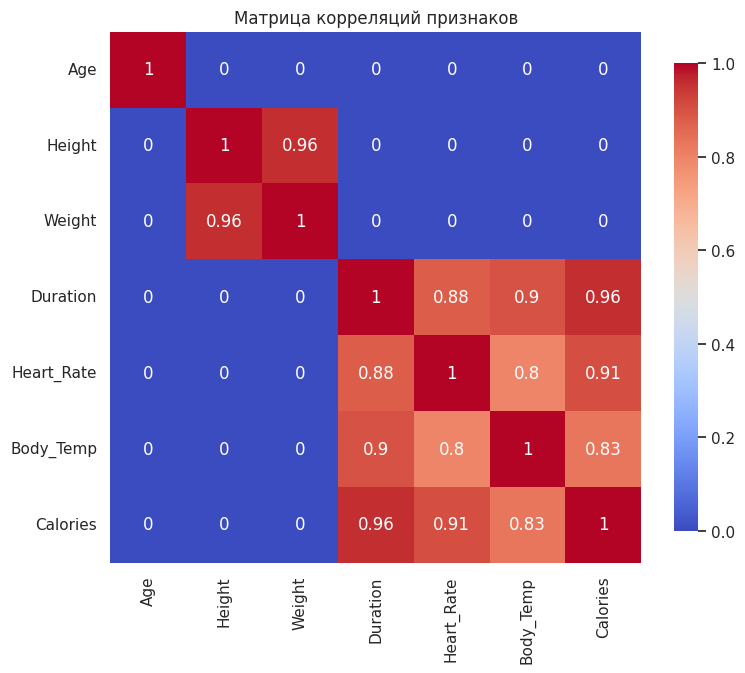

In [21]:
# Матрица корреляций без целевой переменной
corr_matrix = np.round(df[num_cols].corr(),2)
# Зунулим значения не большой корреляции
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Матрица корреляций признаков")
plt.tight_layout()
plt.show()

У некоторых признаков есть сильная корреляция между собой.

In [22]:
# Обнулим диагональ, чтобы исключить самокорреляцию
corr_matrix_no_diag = corr_matrix.copy()
np.fill_diagonal(corr_matrix_no_diag.values, 0)

# Получим пары признаков с корреляцией > 0.9 или < -0.9
high_corr_pairs = (
    corr_matrix_no_diag
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'})
)

# Оставим только высокие корреляции
high_corr_pairs = high_corr_pairs[
    high_corr_pairs['Correlation'].abs() > 0.7
].sort_values(by='Feature 1')

# Удалим дубликаты (A-B и B-A)
high_corr_pairs = high_corr_pairs[high_corr_pairs['Feature 1'] < high_corr_pairs['Feature 2']]

high_corr_pairs.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

,Feature 1,Feature 2,Correlation
0,Calories,Duration,0.96
1,Height,Weight,0.96
2,Calories,Heart_Rate,0.91
3,Body_Temp,Duration,0.90
4,Duration,Heart_Rate,0.88
5,Body_Temp,Calories,0.83
6,Body_Temp,Heart_Rate,0.80


Три признака имеют сильную корреляцию с целевой переменной - это хорошо для модели. Но также половина признаков имеет сильную корреляцию между собой, но т.к. мы будем обучать "деревянную" модель не стоит об этом беспокоиться.

ДФ содержит 750тыс строк и занимает в памяти 88МБ, т.е. достаточно приличный объем данных, можно задуматься над оптимизицией типов, используемых в признаках. Для этого есть специально обученная функция.

In [23]:
df = memory_compression(df)

Исходный размер датасета в памяти равен 95.48 мб.
Конечный размер датасета в памяти равен 17.1 мб.
Экономия памяти = 82.1%


# <font color='#11a642' size='6'> **Разделите данные на трейн и тест**

In [24]:
# Не будем пока выделять целевой признак, т.к. далее будет работа с выбросами
train, valid = train_test_split(df, test_size=0.2, stratify=df['Sex'], random_state=SEED)

# <font color='#11a642' size='6'> **Построение моделей**

## <font color='#11a642' size='5'> Построение модели **Random Forest**. Гиперпараметры подберите либо вручную, либо с помощью GridSearchCV или RandomizedSearchCV


- необходимо ли обрабатывать категориальные признаки заранее?
- необходимо ли обрабатывать пропуски?

In [25]:
# Выше было показано, что пропусков нет - если бы были - их нужно было бы чем-то заполнить

print("Пропущенные значения:", df.isnull().sum().sum())

Пропущенные значения: 0


#### RandomForestRegressor с настройками по умолчанию

In [26]:
# Для Random Forest необходимо обработать категориальные признаки: преобразуем в 0/1

map_dict = {'male': 1, 'female': 0}
train["sex"] = train["Sex"].map(map_dict).astype(np.int8)
valid["sex"] = valid["Sex"].map(map_dict).astype(np.int8)

model_columns = numeric_cols + ["sex"]

params = {'n_jobs': -1}

rf1, metrics_df, _ = train_valid_model(RandomForestRegressor, 1, params,
                                       train, valid, model_columns, target)

metrics_df

,Metric,Train1,Valid1,"Diff1,%"
0,mse,2.09836,14.48578,590.34
1,rmse,1.44857,3.80602,162.74
2,mae,0.86619,2.31118,166.82
3,mape,0.01492,0.03995,167.75
4,r2,0.99946,0.99627,-0.32
5,rmsle,0.02526,0.06404,153.51


Depth:  6 | Train RMSE:   9.39 | Valid RMSE:   9.37
Depth:  8 | Train RMSE:   6.64 | Valid RMSE:   6.67
Depth: 10 | Train RMSE:   4.83 | Valid RMSE:   4.98
Depth: 12 | Train RMSE:   3.77 | Valid RMSE:   4.12
Depth: 14 | Train RMSE:   3.07 | Valid RMSE:   3.78
Depth: 16 | Train RMSE:   2.50 | Valid RMSE:   3.73
Depth: 18 | Train RMSE:   2.01 | Valid RMSE:   3.75
Depth: 20 | Train RMSE:   1.68 | Valid RMSE:   3.78

Ранняя остановка: лучший Valid RMSE (3.73) был на глубине 16


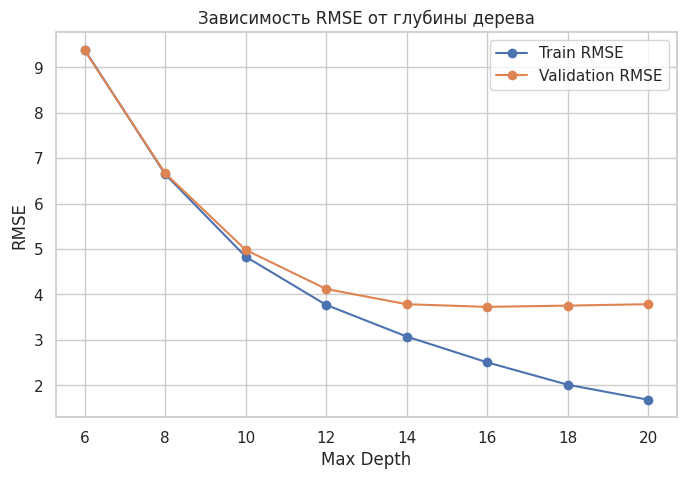

In [27]:
# Подберем оптимальную глубину дерева

opt_depth_rf = find_depth(RandomForestRegressor, params, depths=range(6, 23, 2))

### Подбор гиперпараметров по сетке

- Для запуска GridSearchCV - преобразуйте следующую ячейку в формат "Code"
- Или запустите скрипт: https://github.com/saspav/python_for_pro/blob/main/HW_ML_4_RandomForest.py

#### Результат работы  GridSearchCV:

#### RandomForestRegressor с подобранными гиперпараметрами

In [28]:
rf_best_grid = {'max_depth': 17, 'max_features': 0.5, 'min_samples_leaf': 1,
                'min_samples_split': 8, 'n_estimators': 500, 'n_jobs': -1}

rf2, metrics_df2, _ = train_valid_model(RandomForestRegressor, 2, rf_best_grid,
                                        train, valid, model_columns, target)

metrics_df = pd.concat([metrics_df, metrics_df2.drop(columns=['Metric'])], axis=1)
metrics_df

,Metric,Train1,Valid1,"Diff1,%",Train2,Valid2,"Diff2,%"
0,mse,2.09836,14.48578,590.34,7.41373,13.25001,78.72
1,rmse,1.44857,3.80602,162.74,2.72282,3.64006,33.69
2,mae,0.86619,2.31118,166.82,1.72243,2.17881,26.50
3,mape,0.01492,0.03995,167.75,0.03091,0.03811,23.30
4,r2,0.99946,0.99627,-0.32,0.99810,0.99659,-0.15
5,rmsle,0.02526,0.06404,153.51,0.04921,0.06160,25.17


## <font color='#11a642' size='5'> Построение модели бустинга **XGBoost**. Гиперпараметры подберите либо вручную, либо с помощью GridSearchCV или RandomizedSearchCV


- необходимо ли обрабатывать категориальные признаки заранее?
- необходимо ли обрабатывать пропуски?

#### XGBRegressor с с настройками по умолчанию

In [29]:
# Для XGBRegressor не нужно обрабатывать категориальные признаки,
# в параметрах нужно указать: enable_categorical=True

# XGBRegressor сам определяет оптимальное направление для пропущенных значений
# (ветвление "по умолчанию"). Если в признаке есть NaN, модель научится отправлять такие случаи
# в левую или правую ветвь дерева, чтобы минимизировать ошибку.

model_columns = numeric_cols + cat_cols

params = {'enable_categorical': True, 'n_jobs': -1}

xb1, metrics_df3, _ = train_valid_model(XGBRegressor, 3, params,
                                        train, valid, model_columns, target)

metrics_df = pd.concat([metrics_df, metrics_df3.drop(columns=['Metric'])], axis=1)
metrics_df3

,Metric,Train3,Valid3,"Diff3,%"
0,mse,12.72249,14.52909,14.20
1,rmse,3.56686,3.81170,6.86
2,mae,2.32070,2.37934,2.53
3,mape,0.04097,0.04203,2.59
4,r2,0.99673,0.99626,-0.05
5,rmsle,0.06296,0.06608,4.96


Depth:  6 | Train RMSE:   3.57 | Valid RMSE:   3.81
Depth:  8 | Train RMSE:   3.25 | Valid RMSE:   3.71
Depth: 10 | Train RMSE:   2.90 | Valid RMSE:   3.71
Depth: 12 | Train RMSE:   2.41 | Valid RMSE:   3.77

Ранняя остановка: лучший Valid RMSE (3.71) был на глубине 8


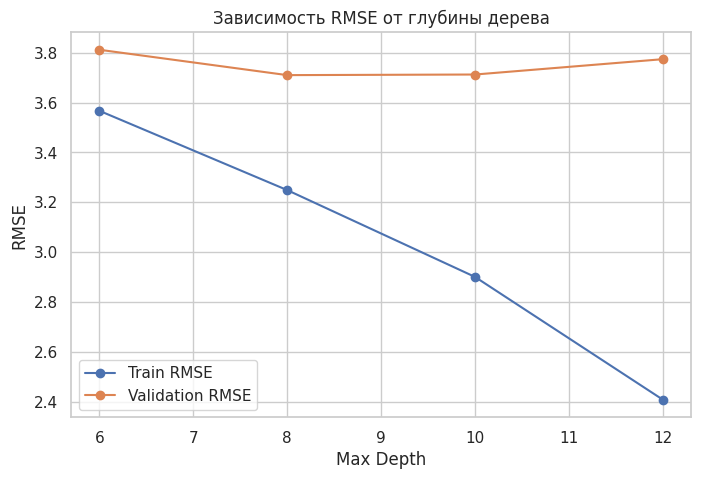

In [30]:
# Подберем оптимальную глубину дерева

opt_depth_xb = find_depth(XGBRegressor, params, depths=range(6, 23, 2))

### Подбор гиперпараметров по сетке

- Запустите скрипт: https://github.com/saspav/python_for_pro/blob/main/HW_ML_4_xgboost.py

#### XGBRegressor с подобранными гиперпараметрами

In [31]:
xb_best_grid = {'eta': 0.028886882560958116, 'max_depth': 7, 'subsample': 0.8,
                'colsample_bytree': 0.9, 'gamma': 0.2110692155097766,
                'enable_categorical': True, 'n_jobs': -1}

xb2, metrics_df4, _ = train_valid_model(XGBRegressor, 4, xb_best_grid,
                                        train, valid, model_columns, target)

metrics_df = pd.concat([metrics_df, metrics_df4.drop(columns=['Metric'])], axis=1)
metrics_df4

,Metric,Train4,Valid4,"Diff4,%"
0,mse,30.36692,30.60842,0.80
1,rmse,5.51062,5.53249,0.40
2,mae,4.08107,4.08261,0.04
3,mape,0.13646,0.13634,-0.08
4,r2,0.99221,0.99212,-0.01
5,rmsle,0.18479,0.18465,-0.07


## <font color='#11a642' size='5'> Построение модели бустинга **LightGBM**. Гиперпараметры подберите либо вручную, либо с помощью GridSearchCV или RandomizedSearchCV


- необходимо ли обрабатывать категориальные признаки заранее?
- необходимо ли обрабатывать пропуски?

#### LGBMRegressor с с настройками по умолчанию

In [32]:
# Для LGBMRegressor не нужно обрабатывать категориальные признаки

# LightGBM автоматически обрабатывает пропуски, но более эффективно за счет оптимизации гистограмм.

params = {'n_jobs': -1, 'verbosity': -1}

lg1, metrics_df5, _ = train_valid_model(LGBMRegressor, 5, params,
                                        train, valid, model_columns, target)
metrics_df = pd.concat([metrics_df, metrics_df5.drop(columns=['Metric'])], axis=1)
metrics_df5

,Metric,Train5,Valid5,"Diff5,%"
0,mse,14.20000,14.63242,3.05
1,rmse,3.76829,3.82523,1.51
2,mae,2.36443,2.38157,0.72
3,mape,0.04368,0.04401,0.75
4,r2,0.99636,0.99623,-0.01
5,rmsle,0.06979,0.07047,0.98


Depth:  6 | Train RMSE:   3.81 | Valid RMSE:   3.87
Depth:  8 | Train RMSE:   3.78 | Valid RMSE:   3.84
Depth: 10 | Train RMSE:   3.78 | Valid RMSE:   3.83
Depth: 12 | Train RMSE:   3.77 | Valid RMSE:   3.83
Depth: 14 | Train RMSE:   3.77 | Valid RMSE:   3.83
Depth: 16 | Train RMSE:   3.77 | Valid RMSE:   3.83
Depth: 18 | Train RMSE:   3.77 | Valid RMSE:   3.83
Depth: 20 | Train RMSE:   3.77 | Valid RMSE:   3.83
Depth: 22 | Train RMSE:   3.77 | Valid RMSE:   3.83


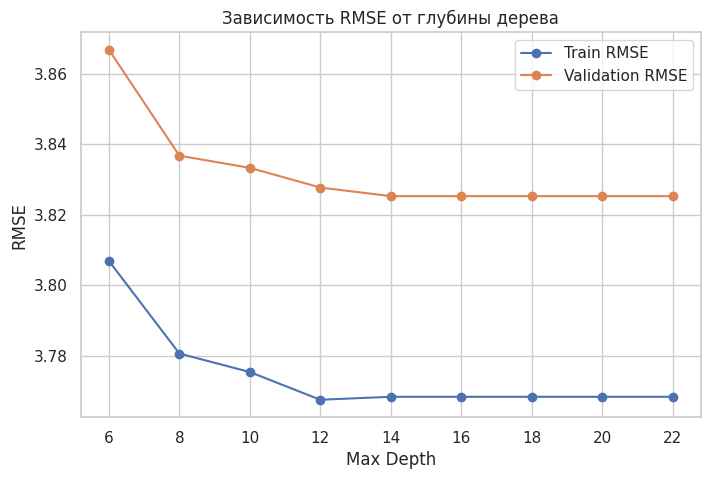

In [33]:
# Подберем оптимальную глубину дерева

opt_depth_lg = find_depth(LGBMRegressor, params, depths=range(6, 23, 2))

### Подбор гиперпараметров по сетке

- Запустите скрипт: https://github.com/saspav/python_for_pro/blob/main/HW_ML_4_lightgbm.py

#### LGBMRegressor с подобранными гиперпараметрами

In [34]:
lg_best_grid = {'boosting_type': 'gbdt', 'learning_rate': 0.2, 'num_leaves': 140,
                'max_depth': 13, 'subsample': 0.7, 'colsample_bytree': 1.0,
                'reg_alpha': 0.393, 'reg_lambda': 0.33888189, 'min_child_samples': 41,
                'bagging_fraction': 0.715, 'bagging_freq': 6, 'n_jobs': -1, 'verbosity': -1}

lg2, metrics_df6, _ = train_valid_model(LGBMRegressor, 6, lg_best_grid,
                                        train, valid, model_columns, target)

metrics_df = pd.concat([metrics_df, metrics_df6.drop(columns=['Metric'])], axis=1)
metrics_df6

,Metric,Train6,Valid6,"Diff6,%"
0,mse,12.17063,13.58028,11.58
1,rmse,3.48864,3.68514,5.63
2,mae,2.18698,2.25878,3.28
3,mape,0.03914,0.04007,2.37
4,r2,0.99688,0.99650,-0.04
5,rmsle,0.06210,0.06387,2.84


## <font color='#11a642' size='5'> Построение модели бустинга **Catboost**. Гиперпараметры подберите либо вручную, либо с помощью GridSearchCV или RandomizedSearchCV


- необходимо ли обрабатывать категориальные признаки заранее?
- необходимо ли обрабатывать пропуски?

#### CatBoostRegressor с с настройками по умолчанию

In [35]:
params = {'cat_features': cat_cols, 'verbose': False}

cb1, metrics_df7, _ = train_valid_model(CatBoostRegressor, 7, params,
                                        train, valid, model_columns, target)

metrics_df = pd.concat([metrics_df, metrics_df7.drop(columns=['Metric'])], axis=1)
metrics_df7

,Metric,Train7,Valid7,"Diff7,%"
0,mse,11.16620,12.65105,13.30
1,rmse,3.34159,3.55683,6.44
2,mae,2.09411,2.12467,1.46
3,mape,0.03752,0.03818,1.77
4,r2,0.99713,0.99674,-0.04
5,rmsle,0.05958,0.06202,4.10


Depth:  6 | Train RMSE:   3.34 | Valid RMSE:   3.56
Depth:  8 | Train RMSE:   3.25 | Valid RMSE:   3.56
Depth: 10 | Train RMSE:   3.13 | Valid RMSE:   3.54
Depth: 12 | Train RMSE:   3.00 | Valid RMSE:   3.55
Depth: 14 | Train RMSE:   2.84 | Valid RMSE:   3.57

Ранняя остановка: лучший Valid RMSE (3.54) был на глубине 10


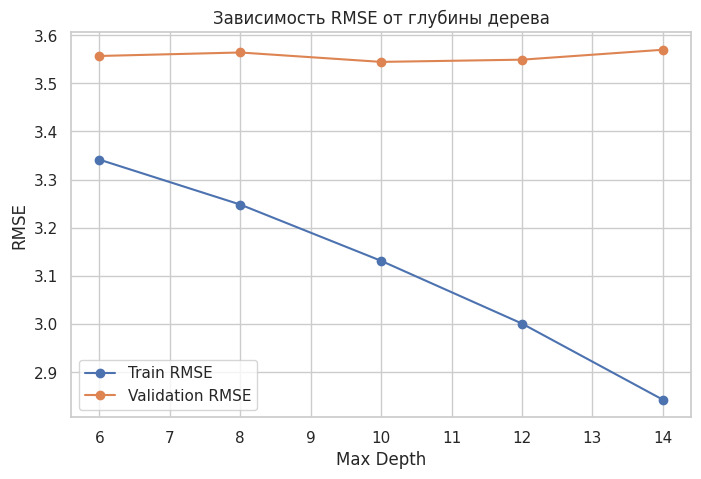

In [36]:
# Подберем оптимальную глубину дерева

opt_depth_cb = find_depth(CatBoostRegressor, params, depths=range(6, 23, 2))

### Подбор гиперпараметров по сетке

- Запустите скрипт: https://github.com/saspav/python_for_pro/blob/main/HW_ML_4_catboost.py

#### CatBoostRegressor с подобранными гиперпараметрами

In [37]:
cb_best_grid = {'learning_rate': 0.1559073096894334, 'depth': 11,
                'l2_leaf_reg': 9.204228730749122, 'min_data_in_leaf': 95,
                'colsample_bylevel': 0.9, 'grow_policy': 'SymmetricTree',
                'bootstrap_type': 'Bernoulli', 'subsample': 1.0,
                'cat_features': cat_cols, 'verbose': False}

cb2, metrics_df8, _ = train_valid_model(CatBoostRegressor, 8, cb_best_grid,
                                        train, valid, model_columns, target)

metrics_df = pd.concat([metrics_df, metrics_df8.drop(columns=['Metric'])], axis=1)
metrics_df8

,Metric,Train8,Valid8,"Diff8,%"
0,mse,9.58477,12.61989,31.67
1,rmse,3.09593,3.55245,14.75
2,mae,1.99618,2.11457,5.93
3,mape,0.03608,0.03761,4.23
4,r2,0.99754,0.99675,-0.08
5,rmsle,0.05691,0.06103,7.25


In [38]:
metrics_df

,Metric,Train1,Valid1,"Diff1,%",Train2,Valid2,"Diff2,%",Train3,Valid3,"Diff3,%",Train4,Valid4,"Diff4,%",Train5,Valid5,"Diff5,%",Train6,Valid6,"Diff6,%",Train7,Valid7,"Diff7,%",Train8,Valid8,"Diff8,%"
0,mse,2.09836,14.48578,590.34,7.41373,13.25001,78.72,12.72249,14.52909,14.20,30.36692,30.60842,0.80,14.20000,14.63242,3.05,12.17063,13.58028,11.58,11.16620,12.65105,13.30,9.58477,12.61989,31.67
1,rmse,1.44857,3.80602,162.74,2.72282,3.64006,33.69,3.56686,3.81170,6.86,5.51062,5.53249,0.40,3.76829,3.82523,1.51,3.48864,3.68514,5.63,3.34159,3.55683,6.44,3.09593,3.55245,14.75
2,mae,0.86619,2.31118,166.82,1.72243,2.17881,26.50,2.32070,2.37934,2.53,4.08107,4.08261,0.04,2.36443,2.38157,0.72,2.18698,2.25878,3.28,2.09411,2.12467,1.46,1.99618,2.11457,5.93
3,mape,0.01492,0.03995,167.75,0.03091,0.03811,23.30,0.04097,0.04203,2.59,0.13646,0.13634,-0.08,0.04368,0.04401,0.75,0.03914,0.04007,2.37,0.03752,0.03818,1.77,0.03608,0.03761,4.23
4,r2,0.99946,0.99627,-0.32,0.99810,0.99659,-0.15,0.99673,0.99626,-0.05,0.99221,0.99212,-0.01,0.99636,0.99623,-0.01,0.99688,0.99650,-0.04,0.99713,0.99674,-0.04,0.99754,0.99675,-0.08
5,rmsle,0.02526,0.06404,153.51,0.04921,0.06160,25.17,0.06296,0.06608,4.96,0.18479,0.18465,-0.07,0.06979,0.07047,0.98,0.06210,0.06387,2.84,0.05958,0.06202,4.10,0.05691,0.06103,7.25


In [39]:
# Поиск лучшей модели по метрикам

find_best_model(metrics_df)

Метрика: mse   --> лучшая модель: Valid8 (12.6199)
Метрика: rmse  --> лучшая модель: Valid8 (3.5524)
Метрика: mae   --> лучшая модель: Valid8 (2.1146)
Метрика: mape  --> лучшая модель: Valid8 (0.0376)
Метрика: r2    --> лучшая модель: Valid8 (0.9968)
Метрика: rmsle --> лучшая модель: Valid8 (0.0610)

Лучшая модель: Valid8 на 6 метриках из 6


### Попробуем лучшую модель обучить на логарифмированной целевой переменной

In [40]:
cb3, metrics_df9, _ = train_valid_model(CatBoostRegressor, 9, cb_best_grid,
                                        train, valid, model_columns, target, target_log=True)

metrics_df = pd.concat([metrics_df, metrics_df9.drop(columns=['Metric'])], axis=1)
metrics_df9

,Metric,Train9,Valid9,"Diff9,%"
0,mse,10.82605,12.79432,18.18
1,rmse,3.29030,3.57691,8.71
2,mae,2.04657,2.11105,3.15
3,mape,0.03412,0.03687,8.08
4,r2,0.99722,0.99671,-0.05
5,rmsle,0.05192,0.06027,16.09


In [41]:
metrics_df

,Metric,Train1,Valid1,"Diff1,%",Train2,Valid2,"Diff2,%",Train3,Valid3,"Diff3,%",Train4,Valid4,"Diff4,%",Train5,Valid5,"Diff5,%",Train6,Valid6,"Diff6,%",Train7,Valid7,"Diff7,%",Train8,Valid8,"Diff8,%",Train9,Valid9,"Diff9,%"
0,mse,2.09836,14.48578,590.34,7.41373,13.25001,78.72,12.72249,14.52909,14.20,30.36692,30.60842,0.80,14.20000,14.63242,3.05,12.17063,13.58028,11.58,11.16620,12.65105,13.30,9.58477,12.61989,31.67,10.82605,12.79432,18.18
1,rmse,1.44857,3.80602,162.74,2.72282,3.64006,33.69,3.56686,3.81170,6.86,5.51062,5.53249,0.40,3.76829,3.82523,1.51,3.48864,3.68514,5.63,3.34159,3.55683,6.44,3.09593,3.55245,14.75,3.29030,3.57691,8.71
2,mae,0.86619,2.31118,166.82,1.72243,2.17881,26.50,2.32070,2.37934,2.53,4.08107,4.08261,0.04,2.36443,2.38157,0.72,2.18698,2.25878,3.28,2.09411,2.12467,1.46,1.99618,2.11457,5.93,2.04657,2.11105,3.15
3,mape,0.01492,0.03995,167.75,0.03091,0.03811,23.30,0.04097,0.04203,2.59,0.13646,0.13634,-0.08,0.04368,0.04401,0.75,0.03914,0.04007,2.37,0.03752,0.03818,1.77,0.03608,0.03761,4.23,0.03412,0.03687,8.08
4,r2,0.99946,0.99627,-0.32,0.99810,0.99659,-0.15,0.99673,0.99626,-0.05,0.99221,0.99212,-0.01,0.99636,0.99623,-0.01,0.99688,0.99650,-0.04,0.99713,0.99674,-0.04,0.99754,0.99675,-0.08,0.99722,0.99671,-0.05
5,rmsle,0.02526,0.06404,153.51,0.04921,0.06160,25.17,0.06296,0.06608,4.96,0.18479,0.18465,-0.07,0.06979,0.07047,0.98,0.06210,0.06387,2.84,0.05958,0.06202,4.10,0.05691,0.06103,7.25,0.05192,0.06027,16.09


In [42]:
# Поиск лучшей модели по метрикам

find_best_model(metrics_df)

Метрика: mse   --> лучшая модель: Valid8 (12.6199)
Метрика: rmse  --> лучшая модель: Valid8 (3.5524)
Метрика: mae   --> лучшая модель: Valid9 (2.1111)
Метрика: mape  --> лучшая модель: Valid9 (0.0369)
Метрика: r2    --> лучшая модель: Valid8 (0.9968)
Метрика: rmsle --> лучшая модель: Valid9 (0.0603)

Лучшая модель: Valid8 на 3 метриках из 6


In [43]:
metrics_8_9 = pd.concat([metrics_df8, metrics_df9.drop(columns=['Metric'])], axis=1)
metrics_8_9.round(4)

,Metric,Train8,Valid8,"Diff8,%",Train9,Valid9,"Diff9,%"
0,mse,9.5848,12.6199,31.67,10.8260,12.7943,18.18
1,rmse,3.0959,3.5524,14.75,3.2903,3.5769,8.71
2,mae,1.9962,2.1146,5.93,2.0466,2.1111,3.15
3,mape,0.0361,0.0376,4.23,0.0341,0.0369,8.08
4,r2,0.9975,0.9968,-0.08,0.9972,0.9967,-0.05
5,rmsle,0.0569,0.0610,7.25,0.0519,0.0603,16.09


### Попробуем обучить модель с признаками без выбросов

In [44]:
# Признаки с выбросами
outlier_cols = ['Height', 'Weight']

# Тут будем хранить результат
results = []

for sex in (0, 1):
    # Выбираем данные для конкретного пола
    X_sex = train[train['sex'] == sex].copy()

    # Вычисляем выбросы только для указанных колонок
    outlier_flags = calculate_outliers(X_sex[outlier_cols], q_range=2)

    # Фильтруем выбросы
    X_filtered = X_sex[~outlier_flags.any(axis=1)]
    results.append(X_filtered)

    # Статистика
    print(f"Пол {sex}:")
    print(f"  Было строк: {len(X_sex)}")
    print(f"  Стало после фильтрации: {len(X_filtered)}")
    print(f"  Удалено строк: {len(X_sex) - len(X_filtered)}")
    print(f"  Процент выбросов: {100 * outlier_flags.any(axis=1).mean():.2f}%\n")

# Объединяем результаты
train_out = pd.concat(results)

# Учим модель с параметрами от GridSearchCV
cb10, metrics10, _ = train_valid_model(CatBoostRegressor, 10, cb_best_grid,
                                       train_out, valid, model_columns, target)

metrics_df = pd.concat([metrics_df, metrics10.drop(columns=['Metric'])], axis=1)
metrics10

Пол 0:
  Было строк: 299432
  Стало после фильтрации: 298571
  Удалено строк: 861
  Процент выбросов: 0.29%

Пол 1:
  Было строк: 298295
  Стало после фильтрации: 297833
  Удалено строк: 462
  Процент выбросов: 0.15%



,Metric,Train10,Valid10,"Diff10,%"
0,mse,9.47761,12.64782,33.45
1,rmse,3.07857,3.55638,15.52
2,mae,1.98916,2.11733,6.44
3,mape,0.03603,0.03774,4.76
4,r2,0.99757,0.99674,-0.08
5,rmsle,0.05678,0.06147,8.27


In [45]:
# Сравним 2 модели 8 и 10

metrics_8_10 = pd.concat([metrics_df8, metrics10.drop(columns=['Metric'])], axis=1)
metrics_8_10.round(4)

,Metric,Train8,Valid8,"Diff8,%",Train10,Valid10,"Diff10,%"
0,mse,9.5848,12.6199,31.67,9.4776,12.6478,33.45
1,rmse,3.0959,3.5524,14.75,3.0786,3.5564,15.52
2,mae,1.9962,2.1146,5.93,1.9892,2.1173,6.44
3,mape,0.0361,0.0376,4.23,0.0360,0.0377,4.76
4,r2,0.9975,0.9968,-0.08,0.9976,0.9967,-0.08
5,rmsle,0.0569,0.0610,7.25,0.0568,0.0615,8.27


In [46]:
# Поиск лучшей модели по метрикам CatBoostRegressor: с выбросами и без выбросов

find_best_model(metrics_8_10)

Метрика: mse   --> лучшая модель: Valid8 (12.6199)
Метрика: rmse  --> лучшая модель: Valid8 (3.5524)
Метрика: mae   --> лучшая модель: Valid8 (2.1146)
Метрика: mape  --> лучшая модель: Valid8 (0.0376)
Метрика: r2    --> лучшая модель: Valid8 (0.9968)
Метрика: rmsle --> лучшая модель: Valid8 (0.0610)

Лучшая модель: Valid8 на 6 метриках из 6


#### Вывод: удаление выбросов ухудшило модель

## <font color='#11a642' size='5'> Выводы:

### <font color='#11a642' size='4'>
- Какая модель оказалась более стабильной и лучше по метрикам?
- Какая модель требует меньше дополнительных обработок данных?
- Какую модель вы выбираете и почему?

## 🧠 В экспериментах принимали участие:
- Модель 1: RandomForestRegressor с настройками по умолчанию
- Модель 2: RandomForestRegressor с подбором гиперпараметров
- Модель 3: XGBRegressor с настройками по умолчанию
- Модель 4: XGBRegressor с подбором гиперпараметров
- Модель 5: LGBMRegressor с настройками по умолчанию
- Модель 6: LGBMRegressor с подбором гиперпараметров
- Модель 7: CatBoostRegressor с настройками по умолчанию
- Модель 8: CatBoostRegressor с подбором гиперпараметров
- Модель 9: CatBoostRegressor с подбором гиперпараметров и логарифмированной целевой переменной
- Модель 10: CatBoostRegressor с подбором гиперпараметров и с удалением выбросов из тренировочных данных
---

### Проведём анализ моделей по метрикам:


## 🔍 **1. Какая модель оказалась более стабильной и лучше по метрикам?**

### 📊 Оценка стабильности:

Оцениваем по `Diff = (Valid - Train) / Train * 100%`.

### 🔝 Лидеры по стабильности:

#### 🔹 **Модель 4 (XGB + гиперпараметры)**:

* MSE Diff: **0.79%**
* RMSE Diff: **0.40%**
* MAE Diff: **0.06%**
* R² Diff: **–0.01%**
* RMSLE Diff: **–0.05%**

→ **Абсолютный лидер по стабильности**: минимальное переобучение.

#### 🔹 **Модель 9 (CatBoost + гиперпараметры + лог target)**:

* MSE Diff: **18.18%**
* RMSE Diff: **8.71%**
* MAE Diff: **3.15%**
* R² Diff: **–0.05%**
* RMSLE Diff: **16.09%**

→ Стабильность **выше**, чем у модели 8 (**31.67% по MSE**), но **уступает модели 4**.

#### 🔹 Также неплохо выглядят:

* **Модель 5 (LGBM default)** и **Модель 6 (LGBM + гиперпараметры)** также имеют невысокие разницы и хорошие абсолютные значения метрик, но уступают по стабильности XGB (Модель 4) и тем более Модели 9.

---

### 💡 Вывод по стабильности:

**🏆 Победитель: Модель 4 (XGB + гиперпараметры)** — наилучшая по **стабильности и обобщающей способности**.

📈 **Модель 9** вышла на **второе место по стабильности среди CatBoost**, опередив **модель 8**.

---

## ⚙️ **2. Какая модель требует меньше дополнительных обработок данных?**

Без изменений:

* **CatBoost** — работает из коробки с категориальными признаками и пропущенными значениями.
* **Модель 9 требует логарифмирования целевой переменной** → требует дополнительной обработки (и обратного преобразования предсказаний).
* **Модели 6 (LGBM с гиперпараметрами)** и **7 (CatBoost default)** — хорошие результаты без дополнительных преобразований целевого признака.

### 💡 Вывод:

**🛠️ Минимум обработки: **CatBoost из коробки (модель 7)** или LGBM (модель 6)**.

---

## ✅ **3. Какую модель вы выбираете и почему?**

### 🧠 Обоснование:

| Модель | Краткое описание                | Сильные стороны                                           | Слабые стороны                            |
| ------ | ------------------------------- | --------------------------------------------------------- | ----------------------------------------- |
| **4**  | XGB + гиперпараметры            | 🟢 Лучшая стабильность, минимальное переобучение          | 🟡 Нет лидирующих метрик |
| **6**  | LGBM + гиперпараметры           | 🟢 Простота, хорошее качество, стабильность               | 🔴 Нет лидирующих метрик                  |
| **7**  | CatBoost default                | 🟢 "Из коробки", без подбора, хорошее качество            | 🟡 Чуть хуже по метрикам                  |
| **8**  | CatBoost + параметры               | 🟡 Хорошие метрики, но слабее по стабильности             | 🔴 MSE Diff = 31.67%                      |
| **9**  | CatBoost + параметры + лог(target) | 🟢 Улучшенные метрики и стабильность после фиксации логов | 🟡 Требует логарифмирования               |

---

### 🎯 Итоговый выбор:

| Приоритет                   | Рекомендуемая модель            | Причина                                           |
| --------------------------- | ------------------------------- | ------------------------------------------------- |
| 🔬 Максимальная точность    | **Модель 9** (CatBoost + лог)   | Отличные метрики и стабильность |
| ⚖️ Лучшая обобщающая модель | **Модель 4** (XGB + параметры)  | Самая стабильная, минимальное переобучение        |
| 🚀 Быстрый запуск           | **Модель 7** (CatBoost default) | Минимум настройки, хорошее качество               |

---

### 📌 Заключение:

* Гипотеза о **пользе логарифмирования целевого признака** подтвердилась — метрики у модели 9 **улучшились**, и она теперь **опережает Модель 8** как по качеству, так и по устойчивости.
* Обучение **CatBoost с удаленим выбросов** выдало метрики хуже, чем у **Модели 8**.
* Если **нужна максимальная точность** → наш выбор **Модель 9 (CatBoost + параметры + лог target)**.

* Если **важна стабильность и обобщающая способность**, или мы **хотим избежать переобучения** → **Модель 4 (XGB + параметры)**:

  * Отличный баланс по всем метрикам с минимальными разницами между train/valid.

* Если **важна простота и "модель из коробки"** с хорошими результатами без обработки → **Модель 7 (CatBoost default)**:

  * Хорошие показатели при минимальных усилиях.